## Summary

Welcome to Part 2 of the In-cloud Science Workflow.

In these examples we will use the [xarray](https://xarray.dev/), [earthaccess](https://nsidc.github.io/earthaccess/), and [harmony-py](https://github.com/nasa/harmony-py) libraries to subset data and make figures using `cartopy`, `matplotlib`, and `geoviews`.

We will go through **three examples of subsetting and plotting data in the Earthdata Cloud:** 

1. Example 1 - `earthaccess` and `xarray` for precipitation estimates from [IMERG, Daily Level 3 data](https://doi.org/10.5067/GPM/IMERGDF/DAY/07)
2. Example 2 - `harmony-py` for direct cloud access & subsetting of precipitable water data from the [DSCOVR EPIC Composite](https://doi.org/10.5067/EPIC/DSCOVR/L2_COMPOSITE_01).
3. Appendix 1 - Snow cover data from [MODIS/Terra, Daily Level 3 data](https://doi.org/10.5067/MODIS/MOD10C1.061)
4. Appendix 2 - Snow mass data from [SMAP, 3-hourly Level 4 data](https://doi.org/10.5067/EVKPQZ4AFC4D)
    
In each example, we will be accessing data directly from Amazon Web Services (AWS), specifically in the us-west-2 region, which is where all cloud-hosted NASA Earthdata reside. This shared compute environment (JupyterHub) is also running in the same location. We will then load the data into Python as an `xarray` dataset.

For `harmony-py`, we will demonstrate an example of pulling data via the cloud from an existing on-premise data server.

See the bottom of the notebook for additional resources, including several tutorials that that served as a foundation for this clinic. Includes: https://github.com/rupesh2/atmospheric_rivers/tree/main

Note: "direct cloud access" is also called "direct S3 access" or simply "direct access".

## Learning Objectives

1. Extract variables, temporal slices, and spatial slices from an `xarray` dataset 
2. Plot data and exclude data points via boolean conditions, using `xarray`, `cartopy`, `matplotlib`, and `rasterio`
3. Plot a polygon geojson file with a basemap using `geoviews` 
4. Conceptualize data subsetting services provided by NASA Earthdata, including Harmony
5. Utilize the `harmony-py` library to request data over the Bay of San Francisco

### Import Required Packages

In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
from pprint import pprint

# Direct access
import earthaccess
from pathlib import Path
import xarray as xr
xr.set_options(display_expand_attrs=False)

# Harmony
from harmony import BBox, Client, Collection, Request, LinkType, CapabilitiesRequest
import datetime as dt
import json
import numpy as np

# Plotting
import geopandas as gpd
import geoviews as gv
from geoviews import opts
gv.extension('bokeh', 'matplotlib', logo=False)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.pyplot as plt
import rioxarray as rxr
%matplotlib inline

## Picking up where we left off

We will authenticate our Earthaccess session, and then open the results like we did in the Search & Discovery section.

In [2]:
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 11/25/2023
Using .netrc file for EDL


## Example 1 - Xarray Subsetting - Precipitation estimates from IMERG, Daily Level 3

### Dataset
We will use the GPM IMERG Final Precipitation L3 Daily dataset for this tutorial.  The IMERG Precipitation Rate provides the rain and snow rates in millimeters per hour (mm/hr). It is estimated by the Integrated Multi-satellitE Retrievals for Global Precipitation Measurement (GPM) (IMERG) algorithm. The IMERG algorithm uses passive-microwave data from the GPM constellation of satellites and infrared data from geosynchronous satellites. IMERG “morphs” observations to earlier or later times using wind from weather-model analyses. The daily IMERG dataset is derived from the half-hourly GPM_3IMERGHH. The derived result represents the final estimate of the daily mean precipitation rate in mm/day.

The IMERG data has 0.1 x 0.1 degree latitude-longitude resolution (approximately 11 by 11 km at the Equator). The grid covers the globe, although precipitation cannot always be estimated near the Poles. The dataset and algorithm are described in the [data user guide](https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/doc/README.GPM.pdf) and the [Algorithm Theoretical Basis Document (ATBD)](https://arthurhou.pps.eosdis.nasa.gov/Documents/IMERG_V07_ATBD_final.pdf). 

Please cite the dataset as:
> Huffman, G.J., E.F. Stocker, D.T. Bolvin, E.J. Nelkin, Jackson Tan (2023), GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 degree V07, Edited by Andrey Savtchenko, Greenbelt, MD, Goddard Earth Sciences Data and Information Services Center (GES DISC), https://doi.org/10.5067/GPM/IMERGDF/DAY/07

In [3]:
collection_id = 'C2723754864-GES_DISC'  # GPM IMERG Final Precipitation L3 1 day 0.1 degree x 0.1 degree V07 (GPM_3IMERGDF)

# Bounds within which we search for data granules
date_start = "2023-02-24"
date_end = "2023-02-26"
date_range = (date_start, date_end)
bbox = (-127.0761, 31.6444, -113.9039, 42.6310)

# For reference (e.g., to visualize in https://geojson.io/), here is a GeoJSON representing the above bounding box:
# {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {}, "geometry": {"type": "LineString", "bbox": [-127.0761, 31.6444, -113.9039, 42.631], "coordinates": [[-113.9039, 42.631], [-127.0761,42.631], [-127.0761, 31.6444], [-113.9039, 31.6444], [-113.9039, 42.631]]}}]}

results = earthaccess.search_data(
    concept_id = collection_id,
    cloud_hosted = True,
    temporal = date_range,
    bounding_box = bbox,
)

ds = xr.open_mfdataset(earthaccess.open(results))

Granules found: 3
 Opening 3 granules, approx size: 0.08 GB
using endpoint: https://data.gesdisc.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

Let's print out all the variable names.

In [4]:
for v in ds.variables:
    print(v)

precipitation
precipitation_cnt
precipitation_cnt_cond
MWprecipitation
MWprecipitation_cnt
MWprecipitation_cnt_cond
randomError
randomError_cnt
probabilityLiquidPrecipitation
lon
lat
time
time_bnds


Of the variables listed above, we are interested in three variables: `precipitation`, `precipitation_cnt_cond`, and `probabilityLiquidPrecipitation`. Let's print their attributes.

In [5]:
ds.variables['precipitation'].attrs

{'units': 'mm/day',
 'long_name': 'Daily mean precipitation rate (combined microwave-IR) estimate. Formerly precipitationCal.'}

In [6]:
ds.variables['precipitation_cnt_cond'].attrs

{'units': 'count',
 'long_name': 'Count of half-hourly precipitation retrievals for the day where precipitation is at least 0.01 mm/hr'}

In [7]:
ds.variables['probabilityLiquidPrecipitation'].attrs

{'units': 'percent',
 'long_name': 'Probability of liquid precipitation',
 'description': 'Probability of liquid precipitation estimated with a diagnostic parameterization using ancillary data. 0=missing values; 1=likely solid; 100=likely liquid or no precipitation.  Screen by positive precipitation or precipitation_cnt_cond to locate meaningful probabilities.'}

### Subsetting

In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection/regridding, and file aggregation. What does subsetting mean? To **subset** means to extract only the portions of a dataset that are needed for a given purpose. Here's a generalized graphic of what we mean. 

![](https://github.com/NASA-Openscapes/earthdata-cloud-cookbook/blob/main/examples/images/subsetting_diagram.png?raw=true){fig-alt="Three maps of the United States are present, with a red bounding box over the state of Colorado. Filtering and subsetting are demonstrated by overlaying SMAP L2 data, with data overlapping and cropping the rectangle, respectively."  width=60%}

There are three primary types of subsetting that we will walk through: 
1. Temporal
2. Spatial
3. Variable

In each case, we will be excluding parts of the dataset that are not wanted using `xarray`. Note that "subsetting" is also called a data "transformation".

In [8]:
ds.time.values

array(['2023-02-24T00:00:00.000000000', '2023-02-25T00:00:00.000000000',
       '2023-02-26T00:00:00.000000000'], dtype='datetime64[ns]')

We start with a subset that represents the U.S. state of California.  Notice the dimensions of the Dataset and each variable.

In [9]:
# Display the full dataset's metadata
ds

<xarray.Dataset>
Dimensions:                         (time: 3, lon: 3600, lat: 1800, nv: 2)
Coordinates:
  * lon                             (lon) float32 -179.9 -179.9 ... 179.9 179.9
  * lat                             (lat) float64 -89.95 -89.85 ... 89.85 89.95
  * time                            (time) datetime64[ns] 2023-02-24 ... 2023...
Dimensions without coordinates: nv
Data variables:
    precipitation                   (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitation_cnt               (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    precipitation_cnt_cond          (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    MWprecipitation                 (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    MWprecipitation_cnt             (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    MWprecipitation_cnt_cond        (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    randomError                     (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    randomError_cnt                 (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lon, lat) int8 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
    time_bnds                       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (9)

In [10]:
# Prepare a subset and display the new dataset's metadata
ds_subset = ds.sel(time='2023-02-24', lat=slice(31, 43), lon=slice(-125, -113)) 
ds_subset

<xarray.Dataset>
Dimensions:                         (lon: 120, lat: 120, nv: 2)
Coordinates:
  * lon                             (lon) float32 -124.9 -124.8 ... -113.1
  * lat                             (lat) float64 31.05 31.15 ... 42.85 42.95
    time                            datetime64[ns] 2023-02-24
Dimensions without coordinates: nv
Data variables:
    precipitation                   (lon, lat) float32 dask.array<chunksize=(120, 120), meta=np.ndarray>
    precipitation_cnt               (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    precipitation_cnt_cond          (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    MWprecipitation                 (lon, lat) float32 dask.array<chunksize=(120, 120), meta=np.ndarray>
    MWprecipitation_cnt             (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    MWprecipitation_cnt_cond        (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    randomError                     (lon, lat) float32 dask.array<chunksize=(120, 120), meta=np.ndarray>
    randomError_cnt                 (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    probabilityLiquidPrecipitation  (lon, lat) int8 dask.array<chunksize=(120, 120), meta=np.ndarray>
    time_bnds                       (nv) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
Attributes: (9)

### Plotting

We will first plot using the methods built-in to the `xarray` package.

Note that, as opposed to the "lazy" loading of metadata previously, this will now perform "eager" computation, pulling the required data chunks.

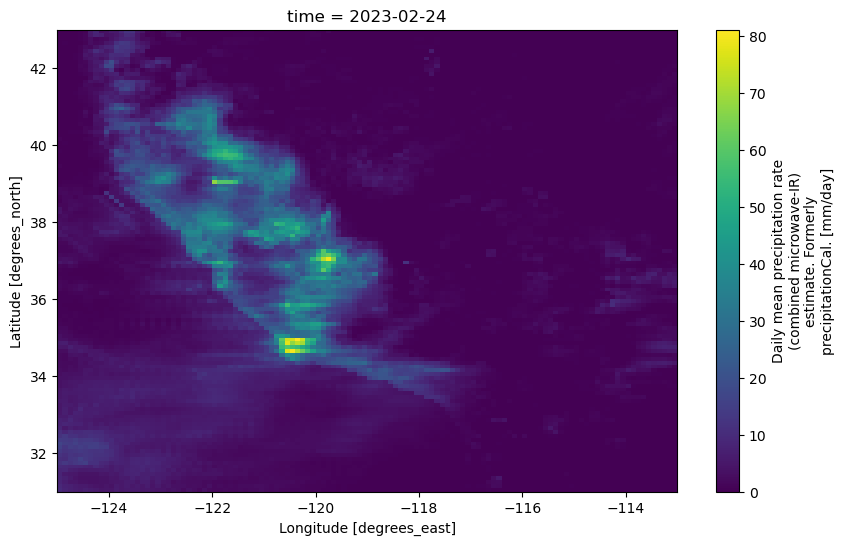

In [11]:
ds_subset['precipitation'].squeeze().plot(figsize=(10,6), x='lon', y='lat');

Now let's utilize the "Probability of liquid precipitation phase" (`probabilityLiquidPrecipitation`) variable to split apart the snow precipitation from everything else.  And we'll utilize `precipitation_cnt_cond` to filter out data points that had less than 0.01 mm/hr preciptation amounts.

In [12]:
snow = ds_subset['precipitation'].where(
    (ds_subset.precipitation_cnt_cond>0) & (ds_subset.probabilityLiquidPrecipitation == 1)
)

prcp = ds_subset['precipitation'].where(
    (ds_subset.precipitation_cnt_cond>0) & (ds_subset.probabilityLiquidPrecipitation != 1)
)

In the following plotting commands, we utilize `cartopy` and `matplotlib` to generate a more customized figure. 

`cartopy` is used to set the map projection (to PlateCarree) and to add U.S. state boundary lines to the figure. `matplotlib`'s pcolormesh is used to generate the color plot, with colors determined by the third argument's value.

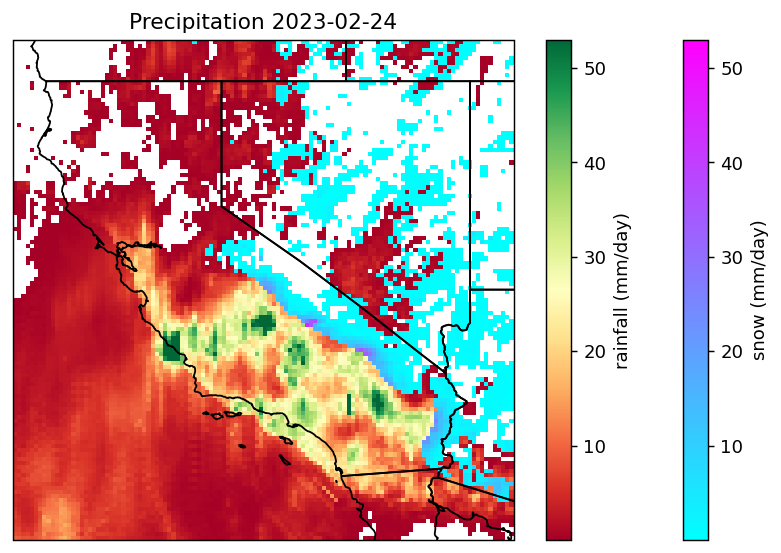

In [13]:
# create the plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(8,5), dpi=130, facecolor="w", subplot_kw=dict(projection=proj))

snowax = plt.pcolormesh(prcp.lon, prcp.lat, snow.squeeze(), vmax=53, cmap='cool')
prcpax = plt.pcolormesh(prcp.lon, prcp.lat, prcp.squeeze(), vmax=53, cmap='RdYlGn')

plt.colorbar(snowax, ax=ax, label="snow (mm/day)")
plt.colorbar(prcpax, ax=ax, label="rainfall (mm/day)")
ax.add_feature(cfeature.STATES)
ax.set_extent([-125, -113.0, 31.0, 43.0], crs=proj)
ax.set_title(f'Precipitation {date_start}')

plt.show()

## Example 2 - Harmony-py Subsetting - Precipitable Water from DSCOVR-EPIC Composite

### Dataset
The NASA Earth Polychromatic Imaging Camera (EPIC)-view Multi-Sensor Global Cloud and Radiance Composites are generated by optimally merging together multiple imagers on low Earth orbit (LEO) satellites (including MODIS, VIIRS, and AVHRR) and geostationary (GEO) satellites (including GOES-13 and -15, METEOSAT-7 and -10, MTSAT-2, and Himawari-8). These provide a seamless global composite product at 5-km resolution by using an aggregated rating that considers five parameters (nominal satellite resolution, pixel time relative to the Earth Polychromatic Imaging Camera (EPIC) observation time, viewing zenith angle, distance from day/night terminator, and sun glint factor) and selects the best observation at the time nearest to the EPIC measurements. The global composite data are then remapped into the EPIC Field of View (FOV) by convolving the high-resolution cloud properties with the EPIC point spread function (PSF) defined with a half-pixel accuracy to produce the EPIC composite. PSF-weighted radiances and cloud properties averages are computed separately for each cloud phase. Ancillary data (i.e., surface type, snow and ice map, skin temperature, precipitable water, etc.) needed for anisotropic factor selections are also included in the composite. These composite images are produced for each observation time of the EPIC instrument (typically 300 to 600 composites per month).


The dataset and development of the composite product is described in the [Khlopenkov et al., 2017](https://doi.org/10.1117/12.2278645) and the [Product Description page](http://doi.org/10.5067/EPIC/DSCOVR/L2_COMPOSITE_01). This dataset can also be viewed in [Earthdata Search](https://cmr.earthdata.nasa.gov/search/concepts/C1576365803-LARC_ASDC.html). 

Please cite the dataset as:
> NASA/LARC/SD/ASDC. (2017). EPIC-view satellite composites for DSCOVR, Version 1 [Data set]. NASA Langley Atmospheric Science Data Center DAAC. Retrieved from https://doi.org/10.5067/EPIC/DSCOVR/L2_COMPOSITE_01.

### Harmony

[Harmony](https://www.earthdata.nasa.gov/learn/articles/harmony-in-the-cloud) is the behind-the-scenes orchestrator for much of the cloud-based transformations happening on NASA's [Earthdata Search](https://search.earthdata.nasa.gov/search) interface. However, requests can also be sent directly to Harmony in a programmatic fashion, either through use of the `harmony-py` Python library or through transmitting underlying HTTP requests.  In this example, we demonstrate the use of `harmony-py`, which was created as an alternative to Harmony's RESTful Application Programming Interface (API) and to make it more convenient to invoke Harmony directly from a Python environment, such as Jupyter notebooks or larger Python applications.

Note that additional examples can be found on the `harmony-py` GitHub page [here](https://github.com/nasa/harmony-py/tree/main).

In [14]:
harmony_client = Client()

#### Inspecting a data collection for its capabilities and variables

The harmony-py package provides useful functions for requesting a report of the capabilities that are configured for a given collection. We will use that function here to inspect the DSCOVR EPIC-view Composite collection.

In [15]:
collection_id = "C1576365803-LARC_ASDC"  # EPIC-view satellite composites for DSCOVR, Version 1
# collection_id = "C1996881146-POCLOUD"

capabilities_request = CapabilitiesRequest(collection_id=collection_id)

capabilities = harmony_client.submit(capabilities_request)
capabilities_str = json.dumps(capabilities, indent=2)

In [21]:
pprint({key: val 
        for key, val in capabilities.items() 
        if key not in ['services', 'variables']}
      )

{'bboxSubset': True,
 'capabilitiesVersion': '2',
 'concatenate': False,
 'conceptId': 'C1576365803-LARC_ASDC',
 'outputFormats': ['application/netcdf', 'application/x-netcdf4'],
 'reproject': False,
 'shapeSubset': True,
 'shortName': 'DSCOVR_EPIC_L2_COMPOSITE',
 'variableSubset': True}


In [17]:
pprint([v["name"] for v in capabilities["variables"]])

['clear_sky/BT_10.8um',
 'clear_sky/BT_12.0um',
 'clear_sky/BT_3.75um',
 'clear_sky/BT_6.75um',
 'clear_sky/LW_broadband_flux',
 'clear_sky/pixel_fraction',
 'clear_sky/ref_0.63um',
 'clear_sky/ref_0.86um',
 'clear_sky/skin_temperature',
 'clear_sky/SW_broadband_albedo',
 'clear_sky/SW_broadband_albedo_EPIC',
 'EPIC/band_680nm',
 'EPIC/centroid_mean_latitude',
 'EPIC/centroid_mean_longitude',
 'EPIC/ndvi',
 'EPIC/relative_azimuth',
 'EPIC/solar_zenith',
 'EPIC/view_zenith',
 'general/lat',
 'general/lon',
 'general/MOA_skin_temperature',
 'general/precipitable_water',
 'general/relative_azimuth',
 'general/relative_time',
 'general/satellite_ID',
 'general/solar_zenith',
 'general/surface_type_fraction',
 'general/surface_type_index',
 'general/surface_U_wind',
 'general/surface_V_wind',
 'general/vertical_temperature_change',
 'general/view_zenith',
 'global_flux/albedo_epic',
 'global_flux/albedo_hidden',
 'global_flux/epic_view_mask',
 'global_flux/insolation_epic',
 'global_flux/in

In [18]:
pprint(capabilities["services"])

[{'capabilities': {'output_formats': ['application/netcdf',
                                      'application/x-netcdf4'],
                   'subsetting': {'bbox': True,
                                  'shape': True,
                                  'temporal': True,
                                  'variable': True}},
  'href': 'https://cmr.earthdata.nasa.gov/search/concepts/S1962070864-POCLOUD',
  'name': 'podaac/l2-subsetter'}]


### Subsetting

#### Define an area of interest

For this example, we will use a GeoJSON to specify a non-rectangular region instead of a simpler, rectangular bounding box.  We will use the GeoJSON that defines a region around San Francisco.

In [22]:
# Read the GeoJSON into a GeoDataFrame
sf_geojson = '../../2023-Cloud-Workshop-AGU/data/sf_to_sierranvmt.geojson'
gdf = gpd.read_file(sf_geojson)

In [23]:
# We define a Geoview Point so we can visualize the area of interest in relation to San Francisco
sf = (-122.42, 37.77, 'SanFrancisco')
cities_lonlat = gv.Points([sf], vdims='City')

# Generate an image
base = gv.tile_sources.EsriImagery.opts(width=650, height=500)
ocean_map = gv.Polygons(gdf).opts(line_color='yellow', line_width=5, color=None)
base * ocean_map * cities_lonlat.options(size=20, color='red', marker='x')

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]
   .Points.I   :Points   [x,y]   (City)

#### Build a Harmony subsetting request

A Harmony request can include spatial, temporal, and variable subsetting all in the same request.  Here we will request all three types of subsetting to be performed on the EPIC-view Composite dataset.

In [28]:
collection_id = "C1576365803-LARC_ASDC"  # (~9 to 12 minutes to process) EPIC-view satellite composites for DSCOVR, Version 1
# collection_id = "C1996881146-POCLOUD"  # (?)

request = Request(
    collection=Collection(id=collection_id),
    shape=sf_geojson,
    temporal={
        'start': dt.datetime(2016, 2, 24, 12),
        'stop': dt.datetime(2016, 2, 24, 23)   
    },
    # variables=["lat", "lon", "time", "mask", "analysed_sst", "sst_anomaly"]
    variables=["general/relative_time", "general/precipitable_water", "clear_sky/skin_temperature"]
)

In [29]:
job_id = harmony_client.submit(request)
job_id

'e88022bd-3252-4123-a4c5-3aaf816e4373'

In [30]:
harmony_client.status(job_id)

{'status': 'running',
 'message': 'The job is being processed',
 'progress': 0,
 'created_at': datetime.datetime(2023, 11, 17, 20, 37, 9, 752000, tzinfo=tzlocal()),
 'updated_at': datetime.datetime(2023, 11, 17, 20, 37, 9, 752000, tzinfo=tzlocal()),
 'created_at_local': '2023-11-17T20:37:09+00:00',
 'updated_at_local': '2023-11-17T20:37:09+00:00',
 'request': 'https://harmony.earthdata.nasa.gov/C1576365803-LARC_ASDC/ogc-api-coverages/1.0.0/collections/general%2Frelative_time,general%2Fprecipitable_water,clear_sky%2Fskin_temperature/coverage/rangeset?forceAsync=true&subset=time(%222016-02-24T12%3A00%3A00%22%3A%222016-02-24T23%3A00%3A00%22)',
 'num_input_granules': 4,
 'data_expiration': datetime.datetime(2023, 12, 17, 20, 37, 9, 752000, tzinfo=tzlocal()),
 'data_expiration_local': '2023-12-17T20:37:09+00:00'}

In [31]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


In [ ]:
harmony_client.status(job_id)

In [ ]:
results = harmony_client.result_json(job_id, show_progress=True)
# results

In [ ]:
print('\nDownloading results:')
futures = harmony_client.download_all(job_id)

filenames = []
for f in futures:
    fn = f.result()
    filenames.append(fn)
    print(fn)  # f.result() is a filename, in this case

print('\nDone downloading.')

In [ ]:
new_ds_general = xr.open_dataset(filenames[0], group="general", decode_times=False)
new_ds_general

### Plotting

In [ ]:
# Flatten and remove null data points in preparation for plotting.
lons = new_ds_general['lon'].values.flatten()
lats = new_ds_general['lat'].values.flatten()
vals = new_ds_general['precipitable_water'].values.flatten()
good_idcs = ~np.isnan(lons) & ~np.isnan(lats) & ~np.isnan(vals)
lons = lons[good_idcs]
lats = lats[good_idcs]
vals = vals[good_idcs]


# Create figure
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(6, 4), facecolor="w", subplot_kw=dict(projection=proj))

ax_handle = ax.scatter(lons, lats, c=vals, cmap="cool")
plt.colorbar(ax_handle, ax=ax, label="precipitable water")

ax.add_feature(cfeature.STATES)
ax.set_extent([-125, -113.0, 31.0, 43.0], crs=proj)
# ax1.set_title(f'{date}')

ax.set_xticks([-125, -120, -115, -110], crs=proj)
ax.set_yticks([32, 34, 36, 38, 40, 42], crs=proj)
lon_formatter = LongitudeFormatter(number_format='.1f',
                                   degree_symbol='',
                                   dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.1f',
                                  degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.show()

A final note about `harmony-py`: As more transformation services are added and configured to work with existing and new NASA data collections, the capabilities you will be able to harness with `harmony-py` will also grow!

## Appendix 1 - Snow Cover from MODIS/Terra, Daily Level3

### Dataset
We will use MODIS/Terra Snow Cover Daily L3 Global 0.05Deg CMG. The Moderate Resolution Imaging Spectroradiometer (MODIS) global Level-3 (L3) data set provides the percentage of snow-covered land and cloud-covered land observed daily, within 0.05° (approx. 5 km) MODIS Climate Modeling Grid (CMG) cells. 

The dataset and algorithm is described in the [data user guide](https://nsidc.org/sites/default/files/mod10c1-v061-userguide_0.pdf) and the [Product Specific Document](https://nsidc.org/sites/default/files/c61_modis_snow_user_guide.pdf). 

Please cite the dataset as:
> Hall, D. K. and G. A. Riggs. (2021). MODIS/Terra Snow Cover Daily L3 Global 0.05Deg CMG, Version 61. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/MODIS/MOD10C1.061.

Using the dataset DOI, we will use the earthaccess module to search for dataset granules from February 24, 2023, and March 2, 2023.

In [ ]:
doi = '10.5067/MODIS/MOD10C1.061' # MODIS Terra Snowcover

# search granules from Feb 15, 2023
date1 = "2023-02-15"
granules1 = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date1, date1)
)
# search granules from March 02, 2023
date2 = "2023-03-02"
granules2 = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date2, date2)
)

Let's download the granules to the local environment. This is needed as direct access to HDF4 files that MODIS Collection 6.1 comes as is currently not supported. The `earthaccess` module manages the authentication that is required for accessing data.

In [ ]:
earthaccess.download(granules1, local_path='.')
earthaccess.download(granules2, local_path='.')

### Subsetting

Let's open the downloaded granules into a `rioxarray`. The variable `Day_CMG_Snow_Cover` provides daily percent snow in 5km grids. The variable `Snow_Spatial_QA` provides quality indicator for each grid: 0=best, 1=good, 2=ok, 3=poor, 4=other, 237=inland water, 239=ocean, 250=cloud obscured water 252=Antarctica mask, 253=not mapped, 254=no retrieval, and 255=fill. We will only use the grids with 0, 1, and 2 quality flags.

In [ ]:
# open granule from Feb 15, 2023
g_1 = Path(Path(granules1[0].data_links()[0]).name)
if g_1.is_file():
    with rxr.open_rasterio(g_1) as modis:
        print(modis)
        snow_cover1 = modis['Day_CMG_Snow_Cover'][:]
        snow_cover_qa1 = modis['Snow_Spatial_QA'][:]

# open granules from March 02, 2023
g_2 = Path(Path(granules2[0].data_links()[0]).name)
if g_2.is_file():
    with rxr.open_rasterio(g_2) as modis:
        snow_cover2 = modis['Day_CMG_Snow_Cover'][:]
        snow_cover_qa2 = modis['Snow_Spatial_QA'][:]

# Spatially subset and keep only good quality cells
snow_cover_good1 = (
    snow_cover1
    .sel(x=slice(-125, -113), y=slice(43, 31))
    .where((snow_cover_qa1 >= 0) & (snow_cover_qa1 <= 2))
)
snow_cover_good2 = (
    snow_cover2
    .sel(x=slice(-125, -113), y=slice(43, 31))
    .where((snow_cover_qa2 >= 0) & (snow_cover_qa2 <= 2))
)

### Plotting

In [ ]:
# create the plot
proj = ccrs.PlateCarree()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), dpi=130, facecolor="w", subplot_kw=dict(projection=proj))

snowax1 = ax1.pcolormesh(snow_cover_good1.x.values, snow_cover_good1.y.values, snow_cover_good1.values[0], vmax=100, cmap='Blues')
plt.colorbar(snowax1, ax=ax1, label="snow cover (%)")
ax1.add_feature(cfeature.STATES)
ax1.set_title(f'Snow Cover {date1}')

snowax2 = ax2.pcolormesh(snow_cover_good2.x.values, snow_cover_good2.y.values, snow_cover_good2.values[0], vmax=100, cmap='Blues')
plt.colorbar(snowax2, ax=ax2, label="snow cover (%)")
ax2.add_feature(cfeature.STATES)
ax2.set_title(f'Snow Cover {date2}')
plt.show()

## Appendix 2 - Snow Mass from SMAP, 3-hourly Level 4

### Dataset
The Soil Moisture Active Passive (SMAP) L4 Global 3-hourly 9 km EASE-Grid Surface and Root Zone Soil Moisture Geophysical Data (SPL4SMGP) provides a model-derived global 3-hr time average of snow mass in kg/m2.  SMAP L-band brightness temperature data from descending and ascending half-orbit satellite passes (approximately 6:00 a.m. and 6:00 p.m. local solar time, respectively) are assimilated into a land surface model that is gridded using an Earth-fixed, global cylindrical 9 km Equal-Area Scalable Earth Grid, Version 2.0 (EASE-Grid 2.0) projection. Snow mass estimates are based on a snow model component of the NASA Catchment Land Surface Model.

The dataset and algorithm are described in the [data user guide](https://nsidc.org/sites/default/files/documents/user-guide/multi_spl4smau-v007-userguide.pdf) and the [Product Specific Document](https://nsidc.org/sites/default/files/documents/technical-reference/reichle1438.pdf). 

Please cite the dataset as:
> Reichle, R., G. De Lannoy, R. D. Koster, W. T. Crow, J. S. Kimball, Q. Liu, and M. Bechtold. (2022). SMAP L4 Global 3-hourly 9 km EASE-Grid Surface and Root Zone Soil Moisture Geophysical Data, Version 7. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/EVKPQZ4AFC4D.

In [ ]:
# SMAP SPL4SMGP
doi = '10.5067/EVKPQZ4AFC4D'

# search granules from Feb 15, 2023
date1 = "2023-02-15"
granules1 = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date1, date1)
)

# search granules from March 02, 2023
date2 = "2023-03-02"
granules2 = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    temporal=(date2, date2)
)

In [ ]:
# granules from Feb 15, 2023
fh1 = earthaccess.open(granules1)
# open geophysical_data group
ds1 = xr.open_dataset(fh1[0], phony_dims='access', group='Geophysical_Data')
# get location
ds_loc1 = xr.open_dataset(fh1[0], phony_dims='access')

In [ ]:
# granules from March 02, 2023
fh2 = earthaccess.open(granules2)
# open geophysical_data group
ds2 = xr.open_dataset(fh2[0], phony_dims='access', group='Geophysical_Data')
# get location
ds_loc2 = xr.open_dataset(fh2[0], phony_dims='access')

The "snow_mass" variable is within the "Geophysical_Data" group. It provides the average snow mass (or snow water equivalent) over a land fraction of the grid cell, excluding areas of open water and permanent ice. Let's print the attributes of the `snow_mass` variable.

In [ ]:
ds1.variables['snow_mass'].attrs

In [ ]:
# create the plot
proj = ccrs.Projection("EPSG:6933") # EASEGRID 2
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), dpi=130, facecolor="w", subplot_kw=dict(projection=proj))

ca_bounds = [-12060785, -10902950, 3769089, 4995383]

snow_mass1 = ds1.snow_mass.where(ds1.snow_mass>9.4)
snowax1 = ax1.pcolormesh(ds_loc1.x, ds_loc1.y, snow_mass1, vmax=200, cmap='Blues')
plt.colorbar(snowax1, ax=ax1, label="snow mass (kg/m2)")
ax1.add_feature(cfeature.STATES)
ax1.set_extent(ca_bounds, crs=proj)
ax1.set_title(f'Snow Mass {date1}')

snow_mass2 = ds2.snow_mass.where(ds2.snow_mass>9.4)
snowax2 = ax2.pcolormesh(ds_loc2.x, ds_loc2.y, snow_mass2, vmax=200, cmap='Blues')
plt.colorbar(snowax2, ax=ax2, label="snow mass (kg/m2)")
ax2.add_feature(cfeature.STATES)
ax2.set_extent(ca_bounds, crs=proj)
ax2.set_title(f'Snow Mass {date2}')
plt.show()

## Additional Resources

### Tutorials

This clinic was based off of several notebook tutorials including those presented during [past workshop events](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/tutorials/), along with other materials co-created by the NASA Openscapes mentors:
* [2021 Earthdata Cloud Hackathon](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/)
* [2021 AGU Workshop](https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/)
* [Accessing and working with ICESat-2 data in the cloud](https://github.com/nsidc/NSIDC-Data-Tutorials/tree/main/notebooks/ICESat-2_Cloud_Access)
* [Analyzing Sea Level Rise Using Earth Data in the Cloud](https://github.com/betolink/earthaccess-gallery/blob/main/notebooks/Sea_Level_Rise/SSL.ipynb)

### Cloud services

The examples used in the clinic provide an abbreviated and simplified workflow to explore access and subsetting options available through the Earthdata Cloud. There are several other options that can be used to interact with data in the Earthdata Cloud including: 

* [OPeNDAP](https://opendap.earthdata.nasa.gov/) 
    * Hyrax provides direct access to subsetting of NASA data using Python or your favorite analysis tool
    * Tutorial highlighting OPeNDAP usage: https://nasa-openscapes.github.io/earthdata-cloud-cookbook/how-tos/working-locally/Earthdata_Cloud__Data_Access_OPeNDAP_Example.html
* [Zarr-EOSDIS-Store](https://github.com/nasa/zarr-eosdis-store)
    * The zarr-eosdis-store library allows NASA EOSDIS Collections to be accessed efficiently by the Zarr Python library, provided they have a sidecar DMR++ metadata file generated. 
    * Tutorial highlighting this library's usage: https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/09_Zarr_Access.html 

### Support

* [Earthdata Forum](https://forum.earthdata.nasa.gov/)
    * User Services and community support for all things NASA Earthdata, including Earthdata Cloud
* [Earthdata Webinar series](https://www.earthdata.nasa.gov/learn/webinars-and-tutorials)
    * Webinars from DAACs and other groups across EOSDIS including guidance on working with Earthdata Cloud
    * See the [Earthdata YouTube channel](https://www.youtube.com/@NASAEarthdata/featured) for more videos 

END of Notebook.